# Feature engineering: NLP features

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import eli5

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate

from textblob import TextBlob

import lightgbm as lgb

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=24)

import nltk
nltk.download('punkt')
pass


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
fetch_20newsgroups().keys()


dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [3]:
target_names = fetch_20newsgroups()['target_names']


In [4]:
X_train, y_train = fetch_20newsgroups(return_X_y=True)
X_test, y_test = fetch_20newsgroups(subset='test', return_X_y=True)


In [ ]:
print(f"Train: X: {len(X_train)}, y: {len(y_train)}")
print(f"Test: X: {len(X_train)}, y: {len(y_train)}")


Train: X: 11314, y: 11314
Test: X: 11314, y: 11314


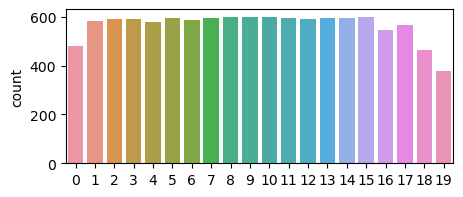

In [ ]:
plt.figure(figsize=(5, 2))
sns.countplot(x=y_train);


In [ ]:
X_train[24]


'From: nodine@lcs.mit.edu (Mark H. Nodine)\nSubject: Re: Quadra SCSI Problems???\nKeywords: Quadra SCSI APS\nOrganization: MIT Laboratory for Computer Science\nLines: 9\n\nI don\'t know about the specific problem mentioned in your\nmessage, but I definitely had SCSI problems between my\nQ700 and my venerable Jasmine Megadrive 10 cartridge\ndrives.  My solution was to get Silverlining.  None of\nthe loops that involved blind writes worked to the drives;\nin fact the only loop that worked was the "Macintosh\nSoftware" loop (whatever that means).\n\n\t--Mark\n'

In [ ]:
print(X_train[24])


From: nodine@lcs.mit.edu (Mark H. Nodine)
Subject: Re: Quadra SCSI Problems???
Keywords: Quadra SCSI APS
Organization: MIT Laboratory for Computer Science
Lines: 9

I don't know about the specific problem mentioned in your
message, but I definitely had SCSI problems between my
Q700 and my venerable Jasmine Megadrive 10 cartridge
drives.  My solution was to get Silverlining.  None of
the loops that involved blind writes worked to the drives;
in fact the only loop that worked was the "Macintosh
Software" loop (whatever that means).

	--Mark



In [ ]:
# Dictionary for saving score
dict_result = {}


In [5]:
def final_results(pipeline, X_train, X_test, model_name):
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    score = accuracy_score(y_test, predictions)
    print(f'Accuracy on test: {score:.3f}')
    if model_name:
        dict_result[model_name] = score
    return eli5.show_prediction(pipeline[1], X_train[24], vec=pipeline[0],
                     feature_names=pipeline[0].get_feature_names_out(),
                     target_names=target_names)


In [6]:
def cv_result(model, model_name=None):
    results = cross_validate(model, X_train, y_train, scoring='accuracy',
               cv=skf, n_jobs=-1, return_train_score=True)
    df_results = pd.DataFrame(results)[['test_score', 'train_score']]
    score = df_results['test_score'].mean(axis=0)
    print(f'Accuracy on cross-validation: {score:.3f}')
    if model_name:
        dict_result[model_name] = (model, score)
    return df_results


## CountVectorizer

### Combine two analyzer: 'word' and 'char_wb'

In [ ]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 5))
vectorizer.fit_transform(X_train)
print(len(vectorizer.vocabulary_))


8069416


In [ ]:
vectorizer = CountVectorizer(
    analyzer='word',
    ngram_range=(1, 5),
    #max_df=0.2,
    min_df=2
)

vectorizer.fit_transform(X_train)
print(len(vectorizer.vocabulary_))


1624248


In [ ]:
vectorizer = CountVectorizer(
    analyzer='word',
    ngram_range=(1, 5),
    max_df=0.2,
    min_df=2
)

vectorizer.fit_transform(X_train)
print(len(vectorizer.vocabulary_))


1624143


In [ ]:
vectorizer = CountVectorizer(
    analyzer='word',
    ngram_range=(1, 5),
    max_df=0.2,
    min_df=3
)

vectorizer.fit_transform(X_train)
print(len(vectorizer.vocabulary_))


670813


In [ ]:
vectorizer = CountVectorizer(
    analyzer='word',
    ngram_range=(1, 5),
    max_df=0.2,
    min_df=5
)

vectorizer.fit_transform(X_train)
print(len(vectorizer.vocabulary_))


246031


In [ ]:
vectorizer = CountVectorizer(
    analyzer='word',
    ngram_range=(1, 5),
    max_df=0.2,
    min_df=10
)

vectorizer.fit_transform(X_train)
print(len(vectorizer.vocabulary_))


83079


In [ ]:
%%time
combined_feature = FeatureUnion([
    ('ngram', CountVectorizer(
        analyzer='word',
        ngram_range=(1, 5),
        max_df=0.5,
        #min_df=5,
        max_features=500_000)
),
    ('char_wb', CountVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 10),
        max_df=0.5,
        #min_df=5,
        max_features=500_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(
        C=0.1, multi_class='multinomial',
        n_jobs=-1, random_state=24, max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.855
CPU times: total: 422 ms
Wall time: 33min 57s


test_score  train_score
0    0.856107          1.0
1    0.852926          1.0

In [ ]:
%%time
combined_feature = FeatureUnion([
    ('ngram', CountVectorizer(
        analyzer='word',
        ngram_range=(1, 5),
        max_df=0.5,
        #min_df=5,
        max_features=300_000)
),
    ('char_wb', CountVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 10),
        max_df=0.5,
        #min_df=5,
        max_features=300_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(
        C=0.1, multi_class='multinomial',
        n_jobs=-1, random_state=24, max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.853
CPU times: total: 500 ms
Wall time: 25min 3s


test_score  train_score
0    0.853102          1.0
1    0.852749          1.0

In [ ]:
%%time
combined_feature = FeatureUnion([
    ('ngram', CountVectorizer(
        analyzer='word',
        ngram_range=(1, 5),
        max_df=0.5,
        min_df=5,
        max_features=300_000)
),
    ('char_wb', CountVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 10),
        max_df=0.5,
        min_df=5,
        max_features=300_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(
        C=0.1, multi_class='multinomial',
        n_jobs=-1, random_state=24, max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.866
CPU times: total: 391 ms
Wall time: 31min 34s


test_score  train_score
0    0.861082          1.0
1    0.864227          1.0
2    0.871917          1.0

In [ ]:
vectorizer = CountVectorizer(
    analyzer='word',
    ngram_range=(1, 5),
    max_df=0.5,
    min_df=5
)

vectorizer.fit_transform(X_train)
print(len(vectorizer.vocabulary_))


246108


In [ ]:
vectorizer = CountVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 10),
    max_df=0.5,
    min_df=5
)

vectorizer.fit_transform(X_train)
print(len(vectorizer.vocabulary_))


687379


In [ ]:
%%time
combined_feature = FeatureUnion([
    ('ngram', CountVectorizer(
        analyzer='word',
        ngram_range=(1, 5),
        max_df=0.5,
        min_df=5,
        max_features=200_000)
),
    ('char_wb', CountVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 10),
        max_df=0.5,
        min_df=5,
        max_features=300_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(
        C=0.1, multi_class='multinomial',
        n_jobs=-1, random_state=24, max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.848
CPU times: total: 234 ms
Wall time: 19min 53s


test_score  train_score
0    0.849920          1.0
1    0.846562          1.0

In [ ]:
%%time
combined_feature = FeatureUnion([
    ('ngram', CountVectorizer(
        analyzer='word',
        ngram_range=(1, 3),
        max_df=0.5,
        min_df=5,
        max_features=200_000)
),
    ('char_wb', CountVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 7),
        max_df=0.5,
        min_df=5,
        max_features=300_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(
        C=0.1, multi_class='multinomial',
        n_jobs=-1, random_state=24, max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.856
CPU times: total: 281 ms
Wall time: 17min 28s


test_score  train_score
0    0.856815          1.0
1    0.854870          1.0

In [ ]:
%%time
combined_feature = FeatureUnion([
    ('ngram', CountVectorizer(
        analyzer='word',
        ngram_range=(1, 3),
        max_df=0.5,
        min_df=5,
        max_features=200_000)
),
    ('char_wb', CountVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 5),
        max_df=0.5,
        min_df=5,
        max_features=300_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(
        C=0.1, multi_class='multinomial',
        n_jobs=-1, random_state=24, max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.859
CPU times: total: 219 ms
Wall time: 11min 12s


test_score  train_score
0    0.856284          1.0
1    0.860880          1.0

In [ ]:
%%time
combined_feature = FeatureUnion([
    ('ngram', CountVectorizer(
        analyzer='word',
        ngram_range=(1, 3),
        max_df=0.5,
        min_df=5,
        max_features=200_000)
),
    ('char_wb', CountVectorizer(
        analyzer='char_wb',
        ngram_range=(4, 7),
        max_df=0.5,
        min_df=5,
        max_features=300_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(
        C=0.1, multi_class='multinomial',
        n_jobs=-1, random_state=24, max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.856
CPU times: total: 188 ms
Wall time: 13min 47s


test_score  train_score
0    0.857168          1.0
1    0.854163          1.0

In [ ]:
%%time
combined_feature = FeatureUnion([
    ('ngram', CountVectorizer(
        analyzer='word',
        ngram_range=(1, 3),
        max_df=0.2,
        min_df=5,
        max_features=200_000)
),
    ('char_wb', CountVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 5),
        max_df=0.2,
        min_df=5,
        max_features=300_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(
        C=0.1, multi_class='multinomial',
        n_jobs=-1, random_state=24, max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.868
CPU times: total: 203 ms
Wall time: 10min 4s


test_score  train_score
0    0.865123          1.0
1    0.871133          1.0

In [ ]:
%%time
combined_feature = FeatureUnion([
    ('ngram', CountVectorizer(
        analyzer='word',
        ngram_range=(1, 3),
        max_df=0.2,
        min_df=5,
        max_features=100_000)
),
    ('char_wb', CountVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 5),
        max_df=0.2,
        min_df=5,
        max_features=300_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(
        C=0.1, multi_class='multinomial',
        n_jobs=-1, random_state=24, max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.868
CPU times: total: 172 ms
Wall time: 9min 51s


test_score  train_score
0    0.865123          1.0
1    0.871133          1.0

In [ ]:
%%time
combined_feature = FeatureUnion([
    ('ngram', CountVectorizer(
        analyzer='word',
        ngram_range=(1, 3),
        max_df=0.2,
        min_df=5,
        max_features=100_000)
),
    ('char_wb', CountVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 6),
        max_df=0.2,
        min_df=5,
        max_features=250_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(
        C=0.1, multi_class='multinomial',
        n_jobs=-1, random_state=24, max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.867
CPU times: total: 172 ms
Wall time: 12min 53s


test_score  train_score
0    0.864062          1.0
1    0.869189          1.0

In [ ]:
%%time
combined_feature = FeatureUnion([
    ('ngram', CountVectorizer(
        analyzer='word',
        ngram_range=(1, 3),
        max_df=0.2,
        min_df=5,
        max_features=100_000)
),
    ('char_wb', CountVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 5),
        max_df=0.2,
        min_df=5,
        max_features=200_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(
        C=0.1, multi_class='multinomial',
        n_jobs=-1, random_state=24, max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.868
CPU times: total: 172 ms
Wall time: 9min 40s


test_score  train_score
0    0.865123          1.0
1    0.871133          1.0

In [ ]:
%%time
combined_feature = FeatureUnion([
    ('ngram', CountVectorizer(
        analyzer='word',
        ngram_range=(1, 3),
        max_df=0.2,
        min_df=5,
        max_features=100_000)
),
    ('char_wb', CountVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 5),
        max_df=0.2,
        min_df=5,
        max_features=200_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(
        C=0.1, multi_class='multinomial',
        n_jobs=-1, random_state=24, max_iter=200))
])

final_results(pipeline, X_train, X_test, 'CountVectorizer_word_charwb')


Accuracy on test: 0.809
CPU times: user 2min 10s, sys: 3.87 s, total: 2min 14s
Wall time: 15min 56s


## TfidfVectorizer

### Combine two analyzer: 'word' and 'char_wb'

In [ ]:
%%time

vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 5),
    max_df=0.2,
    max_features=500_000
)

pipeline = Pipeline([
    ('tf_id', vectorizer),
    ('clf', LogisticRegression(
        C=10, multi_class='multinomial',
        n_jobs=-1, random_state=24, max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.890
CPU times: total: 188 ms
Wall time: 8min 42s


test_score  train_score
0    0.888987     0.999823
1    0.891815     1.000000

### analyzer='char_wb'

In [ ]:
%%time
vectorizer = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 7),
    max_df=0.2,
    min_df=5,
    max_features=500_000
)

pipeline = Pipeline([
    ('tf_id', vectorizer),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.856
CPU times: total: 219 ms
Wall time: 10min 25s


test_score  train_score
0    0.854870     0.984444
1    0.857698     0.983030

In [ ]:
%%time
vectorizer = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(4, 7),
    max_df=0.2,
    min_df=5,
    max_features=500_000
)

pipeline = Pipeline([
    ('tf_id', vectorizer),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.853
CPU times: total: 250 ms
Wall time: 8min 47s


test_score  train_score
0    0.852572     0.984974
1    0.853809     0.983737

In [ ]:
%%time
vectorizer = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 6),
    max_df=0.2,
    min_df=5,
    max_features=500_000
)

pipeline = Pipeline([
    ('tf_id', vectorizer),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.859
CPU times: total: 203 ms
Wall time: 8min 9s


test_score  train_score
0    0.856991     0.985505
1    0.861057     0.984621

In [ ]:
%%time
vectorizer = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 5),
    max_df=0.2,
    min_df=5,
    max_features=500_000
)

pipeline = Pipeline([
    ('tf_id', vectorizer),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.861
CPU times: total: 172 ms
Wall time: 5min 59s


test_score  train_score
0    0.857698     0.985681
1    0.863885     0.985505

In [ ]:
%%time
vectorizer = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 5),
    max_df=0.2,
    min_df=5,
    max_features=200_000
)

pipeline = Pipeline([
    ('tf_id', vectorizer),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.861
CPU times: total: 203 ms
Wall time: 5min 56s


test_score  train_score
0    0.857698     0.985681
1    0.863885     0.985505

### Combine two analyzer: 'word' and 'char_wb'

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(analyzer='word', ngram_range=(1, 1),
                              max_df=0.8, min_df=1, max_features=100_000)),
    ('char_wb', TfidfVectorizer(analyzer='char_wb', ngram_range=(5, 6),
                                max_df=0.2, min_df=2, max_features=500_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.899


test_score  train_score
0    0.897472          1.0
1    0.899770          1.0

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 5),
        max_df=0.2, min_df=1,
        max_features=500_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 5),
        max_df=0.2, min_df=5,
        max_features=200_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.895


test_score  train_score
0    0.892346          1.0
1    0.898179          1.0

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 3),
        max_df=0.2, min_df=2,
        max_features=500_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 7),
        max_df=0.2, min_df=2,
        max_features=500_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.896


test_score  train_score
0    0.895174          1.0
1    0.896588          1.0

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 3),
        max_df=0.2, min_df=2,
        max_features=300_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 7),
        max_df=0.2, min_df=2,
        max_features=500_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.896


test_score  train_score
0    0.894467          1.0
1    0.896765          1.0

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 2),
        max_df=0.2, min_df=2,
        max_features=300_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 7),
        max_df=0.2, min_df=2,
        max_features=500_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.897


test_score  train_score
0    0.894997          1.0
1    0.899593          1.0

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 2),
        max_df=0.2, min_df=2,
        max_features=300_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 7),
        max_df=0.2, min_df=2,
        max_features=300_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.897


test_score  train_score
0    0.894467          1.0
1    0.898886          1.0

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 2),
        max_df=0.2, min_df=2,
        max_features=300_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(4, 6),
        max_df=0.2, min_df=2,
        max_features=300_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.897


test_score  train_score
0    0.894467          1.0
1    0.899240          1.0

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 2),
        max_df=0.2, min_df=2,
        max_features=300_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(4, 6),
        max_df=0.2, min_df=2,
        max_features=200_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.896


test_score  train_score
0    0.893583          1.0
1    0.898710          1.0

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 2),
        max_df=0.2, min_df=2,
        max_features=200_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(4, 6),
        max_df=0.2, min_df=2,
        max_features=300_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.897


test_score  train_score
0    0.894467          1.0
1    0.899240          1.0

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 1),
        max_df=0.2, min_df=2,
        max_features=200_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(4, 6),
        max_df=0.2, min_df=2,
        max_features=300_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.898


test_score  train_score
0    0.896235          1.0
1    0.899593          1.0

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 1),
        max_df=0.2, min_df=2,
        max_features=200_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(4, 5),
        max_df=0.2, min_df=2,
        max_features=300_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.900


test_score  train_score
0    0.897119          1.0
1    0.902599          1.0

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 1),
        max_df=0.2, min_df=2,
        max_features=200_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(4, 5),
        max_df=0.2, min_df=2,
        max_features=200_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.899


test_score  train_score
0    0.896765          1.0
1    0.901538          1.0

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 1),
        max_df=0.2, min_df=2,
        max_features=150_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(4, 5),
        max_df=0.2, min_df=2,
        max_features=250_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.900


test_score  train_score
0    0.897119          1.0
1    0.902245          1.0

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 1),
        max_df=0.2, min_df=2,
        max_features=150_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(4, 5),
        max_df=0.2, min_df=2,
        max_features=250_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=3, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.896


test_score  train_score
0    0.891992     0.998586
1    0.900301     0.999470

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        stop_words='english',
        ngram_range=(1, 1),
        max_df=0.2, min_df=2,
        max_features=150_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(4, 5),
        max_df=0.2, min_df=2,
        max_features=250_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.900


test_score  train_score
0    0.897649          1.0
1    0.902775          1.0

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 1),
        max_df=0.2, min_df=2,
        max_features=150_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(4, 5),
        max_df=0.2, min_df=2,
        max_features=250_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=1000, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

final_results(pipeline, X_train, X_test, 'TfidfVectorizer_word_charwb')


In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 1),
        max_df=0.2, min_df=2,
        max_features=150_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(4, 5),
        max_df=0.2, min_df=2,
        max_features=250_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

final_results(pipeline, X_train, X_test, 'TfidfVectorizer_word_charwb')


Accuracy on test: 0.847


##  HashingVectorizer

In [ ]:
%%time

vectorizer = HashingVectorizer(
    analyzer='word',
    ngram_range=(1, 5),
    n_features=2**20,
)

pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('clf', LogisticRegression(C=10, multi_class='multinomial',
                               n_jobs=-1, random_state=24,
                               max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.839
CPU times: total: 328 ms
Wall time: 20min 59s


test_score  train_score
0    0.837900     0.999823
1    0.839137     1.000000

In [ ]:
%%time

vectorizer = HashingVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    n_features=2**19,
)

pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('clf', LogisticRegression(C=10, multi_class='multinomial',
                               n_jobs=-1, random_state=24,
                               max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.847
CPU times: total: 219 ms
Wall time: 10min 33s


test_score  train_score
0    0.848860     0.999293
1    0.844264     0.999823

In [ ]:
%%time

vectorizer = HashingVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    n_features=2**18,
)

pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('clf', LogisticRegression(C=10, multi_class='multinomial',
                               n_jobs=-1, random_state=24,
                               max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.845
CPU times: total: 188 ms
Wall time: 5min 21s


test_score  train_score
0    0.846208     0.999293
1    0.843910     0.999823

In [ ]:
%%time

vectorizer = HashingVectorizer(
    analyzer='word',
    ngram_range=(1, 3),
    n_features=2**19,
)

pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('clf', LogisticRegression(C=10, multi_class='multinomial',
                               n_jobs=-1, random_state=24,
                               max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.845
CPU times: total: 266 ms
Wall time: 10min 23s


test_score  train_score
0    0.846031     0.999646
1    0.844441     1.000000

In [ ]:
%%time

vectorizer = HashingVectorizer(
    analyzer='word',
    ngram_range=(1, 1),
    n_features=2**19,
)

pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('clf', LogisticRegression(C=10, multi_class='multinomial',
                               n_jobs=-1, random_state=24,
                               max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.843
CPU times: total: 172 ms
Wall time: 9min 4s


test_score  train_score
0    0.842850     0.996995
1    0.842673     0.995757

In [ ]:
%%time

vectorizer = HashingVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 10),
    n_features=2**20,
)

pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('clf', LogisticRegression(C=10, multi_class='multinomial',
                               n_jobs=-1, random_state=24,
                               max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.826
CPU times: total: 203 ms
Wall time: 31min 1s


test_score  train_score
0    0.824288     0.974368
1    0.827647     0.975959

In [ ]:
%%time

vectorizer = HashingVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 10),
    n_features=2**19,
)

pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('clf', LogisticRegression(C=10, multi_class='multinomial',
                               n_jobs=-1, random_state=24,
                               max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.825
CPU times: total: 281 ms
Wall time: 20min 5s


test_score  train_score
0    0.822344     0.974545
1    0.827470     0.975959

In [ ]:
%%time

vectorizer = HashingVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 7),
    n_features=2**19,
)

pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('clf', LogisticRegression(C=10, multi_class='multinomial',
                               n_jobs=-1, random_state=24,
                               max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.829
CPU times: total: 203 ms
Wall time: 17min 58s


test_score  train_score
0    0.825349     0.979141
1    0.831713     0.979318

In [ ]:
%%time

vectorizer = HashingVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 6),
    n_features=2**19,
)

pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('clf', LogisticRegression(C=10, multi_class='multinomial',
                               n_jobs=-1, random_state=24,
                               max_iter=200))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.828
CPU times: total: 234 ms
Wall time: 16min 25s


test_score  train_score
0    0.824996     0.981439
1    0.830829     0.980555

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', HashingVectorizer(
        analyzer='word',
        ngram_range=(1, 4),
        n_features=2**19)),

    ('char_wb', HashingVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 7),
        n_features=2**19))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.861


test_score  train_score
0    0.861234     0.999823
1    0.861764     1.000000

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', HashingVectorizer(
        analyzer='word',
        ngram_range=(1, 2),
        n_features=2**19)),

    ('char_wb', HashingVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 7),
        n_features=2**19))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.863


test_score  train_score
0    0.861587     0.999823
1    0.863532     1.000000

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', HashingVectorizer(
        analyzer='word',
        ngram_range=(1, 1),
        n_features=2**19)),

    ('char_wb', HashingVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 7),
        n_features=2**19))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.858


test_score  train_score
0    0.857698     0.999646
1    0.858229     1.000000

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', HashingVectorizer(
        analyzer='word',
        ngram_range=(1, 2),
        n_features=2**19)),

    ('char_wb', HashingVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 5),
        n_features=2**19))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.861


test_score  train_score
0    0.860527     0.999823
1    0.862295     1.000000

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', HashingVectorizer(
        analyzer='word',
        ngram_range=(1, 2),
        n_features=2**18)),

    ('char_wb', HashingVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 5),
        n_features=2**18))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.862


test_score  train_score
0    0.860704     0.999823
1    0.862825     1.000000

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', HashingVectorizer(
        analyzer='word',
        ngram_range=(1, 1),
        n_features=2**18)),

    ('char_wb', HashingVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 5),
        n_features=2**18))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.857


test_score  train_score
0    0.855047     0.999646
1    0.858759     1.000000

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', HashingVectorizer(
        analyzer='word',
        ngram_range=(1, 2),
        n_features=2**18)),

    ('char_wb', HashingVectorizer(
        analyzer='char_wb',
        ngram_range=(4, 5),
        n_features=2**18))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.861


test_score  train_score
0    0.859289     0.999823
1    0.863355     1.000000

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', HashingVectorizer(
        analyzer='word',
        ngram_range=(1, 2),
        n_features=2**19)),

    ('char_wb', HashingVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 7),
        n_features=2**19))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
score = accuracy_score(y_test, predictions)
print(f'Accuracy on test: {score:.3f}')


Accuracy on test: 0.810


In [ ]:
combined_feature = FeatureUnion([
    ('ngram', HashingVectorizer(
        analyzer='word',
        ngram_range=(1, 2),
        n_features=2**19)),

    ('char_wb', HashingVectorizer(
        analyzer='char_wb',
        ngram_range=(3, 7),
        n_features=2**19))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

pipeline.fit(X_train, y_train)

eli5.explain_prediction(pipeline[1], X_train[24],
                        vec=pipeline[0],
                        target_names=target_names)


Explanation(estimator="LogisticRegression(C=10, max_iter=200, multi_class='multinomial', n_jobs=-1,\n                   random_state=24)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='alt.atheism', feature_weights=FeatureWeights(pos=[FeatureWeight(feature=[{'name': 'char_wb__the', 'sign': 1.0}], weight=0.28925285092417724, std=None, value=-0.104598848163826), FeatureWeight(feature=[{'name': 'ngram__that', 'sign': 1.0}], weight=0.22000509455245207, std=None, value=-0.19824558013652693), FeatureWeight(feature=[{'name': 'ngram__was', 'sign': 1.0}], weight=0.19836791035979306, std=None, value=0.13216372009101796), FeatureWeight(feature=[{'name': 'ngram__edu', 'sign': 1.0}], weight=0.18046327741948914, std=None, value=-0.06608186004550898), FeatureWeight(feature=[{'name': 'ngram__in', 'sign': 1.0}], weight=0.1586410761216884, std=None, value=0.13216372009101796), FeatureWeight(feature=[{'name': 'ngram__of', 'sign': 1.0}], weight=0.1202547863686405, std=None, value=0.06608186004550898), FeatureWeight(feature=[{'name': 'ngram__from', 'sign': 1.0}], weight=0.10503504060295571, std=None, value=-0.06608186004550898), FeatureWeight(feature=[{'name': 'ngram__writes', 'sign': 1.0}], weight=0.08124835031009014, std=None, value=0.06608186004550898), FeatureWeight(feature=[{'name': 'ngram__re', 'sign': 1.0}], weight=0.074503255926565, std=None, value=0.06608186004550898), FeatureWeight(feature=[{'name': 'ngram__subject re', 'sign': 1.0}], weight=0.0658985677695921, std=None, value=-0.06608186004550898), FeatureWeight(feature=[{'name': 'char_wb__ble', 'sign': 1.0}], weight=0.06559958555562734, std=None, value=-0.0836790785310608), FeatureWeight(feature=[{'name': 'char_wb__hat', 'sign': 1.0}], weight=0.0655882826840924, std=None, value=0.0836790785310608), FeatureWeight(feature=[{'name': 'ngram__your', 'sign': 1.0}], weight=0.06357045935373398, std=None, value=-0.06608186004550898), FeatureWeight(feature=[{'name': 'ngram__but', 'sign': 1.0}], weight=0.06326014030095636, std=None, value=0.06608186004550898), FeatureWeight(feature=[{'name': 'ngram__science', 'sign': 1.0}], weight=0.061063521137345624, std=None, value=-0.06608186004550898), FeatureWeight(feature=[{'name': 'ngram__to', 'sign': 1.0}], weight=0.052301344722373584, std=None, value=0.13216372009101796), FeatureWeight(feature=[{'name': 'char_wb__ in', 'sign': 1.0}], weight=0.04566428846704238, std=None, value=0.0627593088982956), FeatureWeight(feature=[{'name': 'ngram__lines', 'sign': 1.0}], weight=0.0432756391866312, std=None, value=0.06608186004550898), FeatureWeight(feature=[{'name': 'ngram__don', 'sign': 1.0}], weight=0.037642992401557114, std=None, value=0.06608186004550898), FeatureWeight(feature=[{'name': 'char_wb__ th', 'sign': 1.0}], weight=0.037006707658339764, std=None, value=-0.1673581570621216), FeatureWeight(feature=[{'name': 'char_wb__ so', 'sign': 1.0}], weight=0.02538981461346254, std=None, value=-0.0418395392655304), FeatureWeight(feature=[{'name': 'char_wb__ion', 'sign': 1.0}], weight=0.02440778155824103, std=None, value=0.0627593088982956), FeatureWeight(feature=[{'name': 'char_wb__hat ', 'sign': 1.0}], weight=0.023525588140712858, std=None, value=-0.0627593088982956), FeatureWeight(feature=[{'name': 'char_wb__ be', 'sign': 1.0}], weight=0.023220793259334568, std=None, value=-0.0209197696327652), FeatureWeight(feature=[{'name': 'ngram__and', 'sign': 1.0}], weight=0.02192850858782693, std=None, value=-0.06608186004550898), FeatureWeight(feature=[{'name': 'char_wb__ no', 'sign': 1.0}], weight=0.021413289666066072, std=None, value=0.0627593088982956), FeatureWeight(feature=[{'name': 'ngram__edu mark', 'sign': 1.0}], weight=0.021124120093501546, std=None, value=-0.06608186004550898), FeatureWeight(feature=[{'name': 'ngram__about the', 'sign': 1.0}], weight=0.02010347380248364, std=None, value=-0.06608186004550898), FeatureWeight(feature=[{'name': 'ngram__in fact', 'sign': 1.0}], weight=0.01970638304738654, s

## TfidfVectorizer with LightGBM 

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 1),
        max_df=0.2, min_df=2,
        max_features=150_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(4, 5),
        max_df=0.2, min_df=2,
        max_features=250_000))
])

X_train_vect = combined_feature.fit_transform(X_train)
X_test_vect = combined_feature.transform(X_test)


In [ ]:
n_rounds = 1000

lgb_train = lgb.Dataset(X_train_vect, y_train,
                        free_raw_data=False)

parameters_lgb = {
    "objective": "multiclass",
    "num_class": 20,
    "learning_rate": 0.1,
    "seed": 24,
    "verbose": 0,
    "force_row_wise": True,
    "metric": "multi_error",
    "num_leaves": 10,
    #"max_depth": 7,

    #regularization
    #"colsample_bytree": 0.6,
    #"subsample": 0.9,
    #"subsample_freq": 1,
    #"min_data_in_leaf": 25,
}

result = lgb.cv(
    parameters_lgb, lgb_train,
    n_rounds, folds=skf,
    eval_train_metric=True,
    callbacks=[lgb.early_stopping(10), lgb.log_evaluation(10)]
    )


Training until validation scores don't improve for 10 rounds
[10]	cv_agg's train multi_error: 0.0986389 + 0.00742443	cv_agg's valid multi_error: 0.227152 + 0.00159095
[20]	cv_agg's train multi_error: 0.035266 + 0.00220965	cv_agg's valid multi_error: 0.197808 + 0.00335867
[30]	cv_agg's train multi_error: 0.00866183 + 0.000707089	cv_agg's valid multi_error: 0.180042 + 0.00220965
[40]	cv_agg's train multi_error: 0.00167934 + 8.83861e-05	cv_agg's valid multi_error: 0.172176 + 0.00265158
[50]	cv_agg's train multi_error: 0.000176772 + 0	cv_agg's valid multi_error: 0.166166 + 0.00424253
[60]	cv_agg's train multi_error: 0 + 0	cv_agg's valid multi_error: 0.163603 + 0.00503801
[70]	cv_agg's train multi_error: 0 + 0	cv_agg's valid multi_error: 0.161481 + 0.00539155
[80]	cv_agg's train multi_error: 0 + 0	cv_agg's valid multi_error: 0.158123 + 0.00574509
[90]	cv_agg's train multi_error: 0 + 0	cv_agg's valid multi_error: 0.154941 + 0.00415415
[100]	cv_agg's train multi_error: 0 + 0	cv_agg's valid mu

In [ ]:
%%time
vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    max_df=0.2,
    min_df=3,
    max_features=100_000
)

X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

n_rounds = 1000

lgb_train = lgb.Dataset(X_train_vect, y_train,
                        free_raw_data=False)

parameters_lgb = {
    "objective": "multiclass",
    "num_class": 20,
    "learning_rate": 0.1,
    "seed": 24,
    "verbose": 0,
    "force_row_wise": True,
    "metric": "multi_error",
    "num_leaves": 20,
}

result = lgb.cv(
    parameters_lgb, lgb_train,
    n_rounds, folds=skf,
    eval_train_metric=True,
    callbacks=[lgb.early_stopping(10), lgb.log_evaluation(10)]
    )


Training until validation scores don't improve for 10 rounds
[10]	cv_agg's train multi_error: 0.0681014 + 0.00199601	cv_agg's valid multi_error: 0.21027 + 0.00210671
[20]	cv_agg's train multi_error: 0.0182516 + 0.00157633	cv_agg's valid multi_error: 0.185964 + 0.00298562
[30]	cv_agg's train multi_error: 0.00229804 + 6.24253e-05	cv_agg's valid multi_error: 0.172087 + 0.00247899
[40]	cv_agg's train multi_error: 0.000176776 + 6.25122e-05	cv_agg's valid multi_error: 0.162542 + 0.00128139
[50]	cv_agg's train multi_error: 4.41969e-05 + 6.25039e-05	cv_agg's valid multi_error: 0.157769 + 0.000740353
[60]	cv_agg's train multi_error: 4.41969e-05 + 6.25039e-05	cv_agg's valid multi_error: 0.152554 + 0.00186366
[70]	cv_agg's train multi_error: 4.41969e-05 + 6.25039e-05	cv_agg's valid multi_error: 0.150345 + 0.00266726
[80]	cv_agg's train multi_error: 4.41969e-05 + 6.25039e-05	cv_agg's valid multi_error: 0.149461 + 0.00229745
[90]	cv_agg's train multi_error: 4.41969e-05 + 6.25039e-05	cv_agg's valid 

## Preprocessing text

In [ ]:
train = fetch_20newsgroups(
    subset='train', random_state=24)

test = fetch_20newsgroups(
    subset='test', random_state=24)


In [ ]:
print(train.data[112])


From: xrcjd@mudpuppy.gsfc.nasa.gov (Charles J. Divine)
Subject: Space Station Redesign Chief Resigns for Health Reasons
Organization: NASA/GSFC Greenbelt Maryland
Lines: 12

Writer Kathy Sawyer reported in today's Washington Post that Joseph Shea, the 
head of the space station redesign has resigned for health reasons.

Shea was hospitalized shortly after his selection in February.  He returned
yesterday to lead the formal presentation to the independent White House panel.
Shea's presentation was rambling and almost inaudible.

Shea's deputy, former astronaut Bryan O'Connor, will take over the effort.

Goldin asserted that the redesign effort is on track.
-- 
Chuck Divine



In [ ]:
df_train = pd.DataFrame(train.data, columns=['data'])
df_train.head(3)


data
0  From: HOLFELTZ@LSTC2VM.stortek.com\nSubject: R...
1  From: grady@netcom.com (1016/2EF221)\nSubject:...
2  From: drp@camelot.bradley.edu (Douglas Pokorny...

In [ ]:
df_test = pd.DataFrame(test.data, columns=['data'])


In [ ]:
# delete From and Lines
df_train['data'] = df_train.data.replace('(From: (.*)\n)|(Lines: [0-9]*\n)', '', regex=True)


In [ ]:
print(df_train['data'][1012])


Organization: City University of New York
Subject: Re: Most recent U.N. members?

   # 179 Czech Republic  # 180 Republic of Slovakia  They were admitted early
      this year.  Liechenstein was also recently admitted.  Also San Marino.
       Both within the last 12 months.  Incredible what passes for a nation-sta
           state nowadays.



In [ ]:
df_test['data'] = df_test.data.replace('(From: (.*)\n)|(Lines: [0-9]*\n)', '', regex=True)


Clear text

In [ ]:
# Replace all number with 'number'
df_train['data'] = df_train['data'].replace('[0-9]+', 'number', regex=True)
df_test['data'] = df_test['data'].replace('[0-9]+', 'number', regex=True)
df_train['data'].head(3)


0    Subject: Re: Need a book\nOrganization: Storag...
1    Subject: powerful "similarity" too\nOrganizati...
2    Subject: ISA bus pin question; re: Diamond Spe...
Name: data, dtype: object

In [ ]:
X_train = df_train['data'].values
X_test = df_test['data'].values
y_train = train.target
y_test = test.target

target_names = train.target_names


In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2))
vectorizer.fit_transform(X_train)
print(len(vectorizer.vocabulary_))


1056501


In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2),
                             max_df=0.6, min_df=2)
vectorizer.fit_transform(X_train)
print(len(vectorizer.vocabulary_))


361252


In [ ]:
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(5, 7))
vectorizer.fit_transform(X_train)
print(len(vectorizer.vocabulary_))


2552485


In [ ]:
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(5, 7),
                             max_df=0.2, min_df=2)
vectorizer.fit_transform(X_train)
print(len(vectorizer.vocabulary_))


849777


In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 1),
        max_df=0.2, min_df=2,
        max_features=150_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(4, 5),
        max_df=0.2, min_df=2,
        max_features=250_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline, 'preproc_TfidfVectorizer_word_charwb')


Accuracy on cross-validation: 0.898


test_score  train_score
0    0.905250     0.999646
1    0.890578     1.000000

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 1),
        max_df=0.2, min_df=2,
        max_features=150_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(4, 7),
        max_df=0.2, min_df=2,
        max_features=250_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.896


test_score  train_score
0    0.901891     0.999646
1    0.890932     1.000000

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 2),
        max_df=0.8, min_df=2,
        max_features=200_000)),

        ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(6, 7),
        max_df=1, min_df=1,
        max_features=500_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=15, random_state=24, max_iter=500,
                               multi_class='multinomial'))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.897


test_score  train_score
0    0.899593     0.999646
1    0.895351     1.000000

In [ ]:
combined_feature = FeatureUnion([
    ('ngram', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 1),
        max_df=0.2, min_df=2,
        max_features=150_000)),

    ('char_wb', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(6, 7),
        max_df=0.5, min_df=2,
        max_features=300_000))
])

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=10, max_iter=200,
                               multi_class='multinomial',
                               n_jobs=-1, random_state=24))
])

cv_result(pipeline)


Accuracy on cross-validation: 0.896


test_score  train_score
0    0.901715     0.999646
1    0.890578     1.000000

## Feature Engineering

In [ ]:
train = fetch_20newsgroups(
    subset='train', random_state=24)

test = fetch_20newsgroups(
    subset='test', random_state=24)


In [ ]:
y_train = fetch_20newsgroups(subset='train', random_state=24).target
y_test = fetch_20newsgroups(subset='test', random_state=24).target


In [ ]:
df_train = pd.DataFrame(train.data, columns=['data'])
df_test = pd.DataFrame(test.data, columns=['data'])


In [ ]:
target_names = train.target_names


In [ ]:
def get_text_level_features(df, visualize=True):
    df['subject'] = df['data'].str.extract('Subject: (.*)\n').replace('Re: ', '', regex=True)

    df['keywords'] = df['data'].str.extract('\nKeywords: (.*)\n').fillna('')

    df['text'] = df['data'].apply(lambda x: x.partition('\n\n')[-1])  # lines count

    df['lines_cnt'] = df_train['data'].str.extract('Lines: (.*)\n')

    df['text_sentence_cnt'] = df['text'].apply(lambda s: len(TextBlob(s).sentences)) # sentence count

    df['keywords_cnt'] = df['keywords'].apply(lambda s: len(TextBlob(s).words)) # word count

    df['subject_words_cnt'] = df['subject'].apply(lambda s: len(TextBlob(s).words)) # word count

    capital_letter_pattern = re.compile(r'([A-Z]+)')
    df['capital_letter_cnt'] = df['text'].apply(lambda s: len(re.findall(capital_letter_pattern, s)))

    df['text_words_cnt'] = df['text'].apply(lambda s: len(TextBlob(s).words))

    df['exclamation_cnt'] = df['text'].str.count('\!') # exclamation mark count

    df['question_cnt'] = df['text'].str.count('\?') # question mark count

    # uppercase words cnt
    regex_uppercase_pattern = re.compile(
        r'(\b[0-9]*[A-Z]+[0-9]*[A-Z]+[0-9]*\b)'
        )
    df['upper_word_cnt'] = df['text'].apply(lambda s: len(re.findall(regex_uppercase_pattern, s)))

    # emails
    regex_email = re.compile(
        r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)",
        re.U | re.M
    )

    df['emails_cnt'] = df.text.apply(
        lambda x: len(re.findall(regex_email, x))
    )

    # variety of phone number formats
    regex_phone = re.compile(
        r"""
        ((?:\+|00)[17](?: |\-)?|(?:\+|00)[1-9]\d{0,2}(?: |\-)?|
        (?:\+|00)1\-\d{3}(?: |\-)?)?(0\d|\([0-9]{3}\)|[1-9]{0,3})
        (?:((?: |\-)[0-9]{2}){4}|((?:[0-9]{2}){4})|
        ((?: |\-)[0-9]{3}(?: |\-)[0-9]{4})|([0-9]{7}))
        """,
        re.M | re.I | re.VERBOSE
    )

    df['phones_cnt'] = df.text.apply(
        lambda x: len(re.findall(regex_phone, x))
    )

    # capitalized sequences like John Doe and Barack Obama
    regex_capitalized_sequences = re.compile(
        r"""
        ([A-Z][a-z]+(?=\s[A-Z])(?:\s[A-Z][a-z]+)+)
        """,
        re.U | re.M | re.VERBOSE
    )

    df['possible_names_cnt'] = df.text.apply(
        lambda x: len(re.findall(regex_capitalized_sequences, x))
    )


    # some currency expressions, like 100USD, 1.25$, £123,334 etc.
    regex_currency = re.compile(
        r"""
        (?:\-|\+)*[0-9]+(?:[\.\,]{1}[0-9]+)*\s*(?:\$|£|usd)|
        (?:\-|\+)*(?:\$|£|usd)\s*[0-9]+(?:[\.\,]{1}[0-9]+)*
        """,
        re.M | re.I | re.VERBOSE
    )

    df['possible_currency_cnt'] = df.text.apply(
        lambda x: len(re.findall(regex_currency, x))
    )

    # number
    regex_number = re.compile(
        r"""
        [0-9]+
        """,
        re.M | re.I | re.VERBOSE
    )

    df['number_cnt'] = df.text.apply(
        lambda x: len(re.findall(regex_number, x))
    )
    # subjectivity
    df['subjectivity_text'] = df['text'].apply(lambda s: TextBlob(s).sentiment.subjectivity)

    def purity(sentences):
        # obtain polarities across the sentences
        polarities = np.array([x.sentiment.polarity for x in TextBlob(sentences).sentences])
        return polarities.sum() / np.abs(polarities).sum()

    # "purity" of text
    df['purity_text'] = df['text'].apply(purity)
    df['purity_text'].fillna(0, inplace=True)

    return df


In [ ]:
%%time
train = get_text_level_features(df_train)
test = get_text_level_features(df_test)


CPU times: total: 5min 45s
Wall time: 6min 1s


In [ ]:
train.head(3)


data  \
0  From: HOLFELTZ@LSTC2VM.stortek.com\nSubject: R...   
1  From: grady@netcom.com (1016/2EF221)\nSubject:...   
2  From: drp@camelot.bradley.edu (Douglas Pokorny...   

                                           subject keywords  \
0                                      Need a book            
1                        powerful "similarity" too            
2  ISA bus pin question; re: Diamond Speedstar 24X            

                                                text lines_cnt  \
0  In article <Apr.14.03.08.18.1993.5458@athos.ru...        37   
1  A Unix tool of cryptographic significance is a...       107   
2  \nToday I recieved a in-warranty replacement f...        33   

   text_sentence_cnt  keywords_cnt  subject_words_cnt  capital_letter_cnt  \
0                  8             0                  3                  71   
1                 36             0                  3                 104   
2                  8             0                  8                  39   

   text_words_cnt  exclamation_cnt  question_cnt  upper_word_cnt  emails_cnt  \
0             176                2             0               4           0   
1             705                1             3              23           0   
2             143                0             3               8           0   

   phones_cnt  possible_names_cnt  possible_currency_cnt  number_cnt  \
0           0                  10                      0           6   
1           0                   4                      0          34   
2           0                   2                      0           5   

   subjectivity_text  purity_text  
0           0.584211     1.000000  
1           0.559719     0.733929  
2           0.440747     1.000000

In [ ]:
train.to_csv('train_text_level_features.csv')
test.to_csv('test_text_level_features.csv')


In [ ]:
numeric_features = train.select_dtypes('number').columns
X_train, X_test = train[numeric_features], test[numeric_features]

pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(C=10, multi_class='multinomial',
                               n_jobs=-1, random_state=24,
                               max_iter=200))
])

results(pipeline)


accuracy: 0.179


In [ ]:
n_rounds = 500
lgb_train = lgb.Dataset(X_train, y_train,
                        free_raw_data=False)
n_rounds=500
parameters_lgb = {
    "objective": "multiclass",
    "num_class": 20,
    "learning_rate": 0.1,
    "seed": 24,
    "verbose": 0,
    "metric": "multi_error",
    "force_row_wise": True,
    "num_leaves": 5
}

result = lgb.cv(
    parameters_lgb, lgb_train,
    n_rounds, folds=skf,
    eval_train_metric=True,
    callbacks=[lgb.early_stopping(10), lgb.log_evaluation(10)])


Training until validation scores don't improve for 10 rounds
[10]	cv_agg's train multi_error: 0.748056 + 0.0029398	cv_agg's valid multi_error: 0.794768 + 0.00748331
[20]	cv_agg's train multi_error: 0.718579 + 0.0018909	cv_agg's valid multi_error: 0.783984 + 0.00598385
[30]	cv_agg's train multi_error: 0.693698 + 0.00280936	cv_agg's valid multi_error: 0.77824 + 0.00436788
[40]	cv_agg's train multi_error: 0.672751 + 0.0027296	cv_agg's valid multi_error: 0.774174 + 0.00668756
[50]	cv_agg's train multi_error: 0.653836 + 0.00316777	cv_agg's valid multi_error: 0.770374 + 0.00410155
[60]	cv_agg's train multi_error: 0.636468 + 0.00319432	cv_agg's valid multi_error: 0.766838 + 0.00439568
[70]	cv_agg's train multi_error: 0.619189 + 0.00301769	cv_agg's valid multi_error: 0.768075 + 0.00404892
Early stopping, best iteration is:
[60]	cv_agg's train multi_error: 0.636468 + 0.00319432	cv_agg's valid multi_error: 0.766838 + 0.00439568


In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))
vectorizer.fit_transform(train['subject'])
print(len(vectorizer.vocabulary_))


7259


In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), max_df=1.0, min_df=3)
vectorizer.fit_transform(train['subject'])
print(len(vectorizer.vocabulary_))


3248


In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))
vectorizer.fit_transform(train['keywords'])
print(len(vectorizer.vocabulary_))


1315


In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), max_df=1.0, min_df=3)
vectorizer.fit_transform(train['keywords'])
print(len(vectorizer.vocabulary_))


260


In [ ]:
col_to_drop = ['data', 'keywords']
feats = [x for x in df_train.columns if x not in col_to_drop]
X_train = df_train[feats].copy()
X_test = df_test[feats].copy()


In [ ]:
transformer_ngram = ColumnTransformer([
    ('subject', TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df=3), 'subject'),
    ('text', TfidfVectorizer(analyzer='word', ngram_range=(1, 2),  max_df=0.2, min_df=2), 'text')
])

transformer_char_wb = ColumnTransformer([
    ('text', TfidfVectorizer(analyzer='char_wb', ngram_range=(5, 7), max_df=0.2, min_df=2), 'text')
])

numeric_transformer = ColumnTransformer([
    ('impute', SimpleImputer(strategy='mean'), numeric_features),
    ('scaler', StandardScaler(), numeric_features)
])

combined_feature = FeatureUnion([
    ('ngram', transformer_ngram),
    ('char_wb', transformer_char_wb),
    ('stats', numeric_transformer)
    ],
    transformer_weights={
            'ngram': 1,
            'char_wb': 1,
            'stats': .1,
        }
)

pipeline = Pipeline([
    ('vectorizer', combined_feature),
    ('clf', LogisticRegression(C=1, multi_class='multinomial',
                               n_jobs=-1, random_state=24,
                               max_iter=200))
])

cv_result(pipeline, 'with_text_level_features')


accuracy: 0.458


## Summary

In [ ]:
df_result = pd.DataFrame.from_dict(dict_result, orient='index', columns=['accuracy_score'])
df_result


accuracy_score
CountVectorizer_word_charwb                   0.868
TfidfVectorizer_word                          0.890
TfidfVectorizer_charwb                        0.861
TfidfVectorizer_word_charwb                   0.900
HashingVectorizer_word                        0.847
HashingVectorizer_charwb                      0.829
HashingVectorizer_word_charwb                 0.863
preproc_TfidfVectorizer_word_charwb           0.898
with_text_level_features                      0.458

In [ ]:
df_result[df_result['accuracy_score'] == max(df_result['accuracy_score'] )][['model', 'accuracy_score']]


accuracy_score
TfidfVectorizer_word_charwb             0.9

The best result for model with TfidfVectorizer and combine 'word' and 'char_wb' analyzer.